In [13]:
# Restart kernel and reload modules
import importlib
import sys
if 'fugu.bricks.lca_bricks' in sys.modules:
    importlib.reload(sys.modules['fugu.bricks.lca_bricks'])
if 'fugu.bricks' in sys.modules:
    importlib.reload(sys.modules['fugu.bricks'])


In [14]:

from fugu.bricks import LCABrick
from fugu.backends import slca_Backend  
import numpy as np
from fugu import Scaffold

Phi_demo = np.array([
    [0.3313, 0.8148, 0.4364],
    [0.8835, 0.3621, 0.2182],
    [0.3313, 0.4527, 0.8729],
], dtype=float)

s_demo = np.array([0.5, 1.0, 1.5], dtype=float)
lam_demo = 0.1
dt = 1e-3
scaffold = Scaffold()

scaffold.add_brick(
    LCABrick(Phi=Phi_demo, input_signal=s_demo, dt=dt, lam=lam_demo),
    output=True
)

scaffold.lay_bricks()

In [15]:
graph = scaffold.graph
print(f"Graph has {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges")

lca_neurons = [n for n in graph.nodes() if 'neuron_' in n]
print(f"Found {len(lca_neurons)} LCA neurons:")
for i, neuron in enumerate(lca_neurons): 
    print(f"  {neuron}: {graph.nodes[neuron]}")

print(f"\nExample edges (inhibitory connections):")
for i, (src, dst, data) in enumerate(graph.edges(data=True)):
    print(f"  {src} -> {dst}: weight={data.get('weight', 'N/A')}, delay={data.get('delay', 'N/A')}")

Graph has 4 nodes and 6 edges
Found 3 LCA neurons:
  Brick-4:neuron_0: {'index': 0, 'threshold': 1.0, 'reset_voltage': 0.0, 'leakage_constant': 1.0, 'potential': 0.0, 'bias': 0.001446029170296057, 'p': 1.0, 'neuron_type': 'GeneralNeuron', 'compartment': {'name': 'RecurrentInhibition', 'tau_syn': 1, 'dt': 0.001}, 'brick': 'Brick-4', 'neuron_number': 1}
  Brick-4:neuron_1: {'index': 1, 'threshold': 1.0, 'reset_voltage': 0.0, 'leakage_constant': 1.0, 'potential': 0.0, 'bias': 0.0013485842304498028, 'p': 1.0, 'neuron_type': 'GeneralNeuron', 'compartment': {'name': 'RecurrentInhibition', 'tau_syn': 1, 'dt': 0.001}, 'brick': 'Brick-4', 'neuron_number': 2}
  Brick-4:neuron_2: {'index': 2, 'threshold': 1.0, 'reset_voltage': 0.0, 'leakage_constant': 1.0, 'potential': 0.0, 'bias': 0.0016457407388699454, 'p': 1.0, 'neuron_type': 'GeneralNeuron', 'compartment': {'name': 'RecurrentInhibition', 'tau_syn': 1, 'dt': 0.001}, 'brick': 'Brick-4', 'neuron_number': 3}

Example edges (inhibitory connections

In [16]:
# Reload the backend with fixes
import importlib
importlib.reload(sys.modules['fugu.backends.slca_backend'])
from fugu.backends import slca_Backend

# Re-create and compile the backend with fixes
backend = slca_Backend()
backend.compile(
    scaffold=scaffold,
    compile_args={
        'y': s_demo,
        'Phi': Phi_demo,
        'T_steps': 100000,  # Reduce for testing
        't0_steps': 1000,
    }
)
print(f"Neuron biases set to: {backend.b}")
print(f"S-LCA parameters: tau={backend.tau}, lam={backend.lam}")
print(f"Network dimensions: {backend.N} neurons")

# Verify neuron parameters
print("\nNeuron parameters verification:")
for name, neuron in backend.nn.nrns.items():
    if "neuron_" in name and "complete" not in name:
        b = getattr(neuron, '_b', None)
        lam = getattr(neuron, 'lam', None)
        def fmt(val, spec):
            if isinstance(val, (int, float)):
                return f"{val:{spec}}"
            return 'not set' if val is None else str(val)
        print(f"  {name}: bias={fmt(b, '.4f')}, lam={fmt(lam, '.3f')}")

<class 'fugu.simulators.SpikingNeuralNetwork.compartments.RecurrentInhibition'>
<class 'fugu.simulators.SpikingNeuralNetwork.compartments.RecurrentInhibition'>
<class 'fugu.simulators.SpikingNeuralNetwork.compartments.RecurrentInhibition'>
Neuron biases set to: [1.54602917 1.44858423 1.74574074]
S-LCA parameters: tau=0.01, lam=0.1
Network dimensions: 3 neurons

Neuron parameters verification:
  Brick-4:neuron_0: bias=0.0014, lam=not set
  Brick-4:neuron_1: bias=0.0013, lam=not set
  Brick-4:neuron_2: bias=0.0016, lam=not set


In [17]:
# Reload backend with the array division fix
import importlib
importlib.reload(sys.modules['fugu.backends.slca_backend'])
from fugu.backends import slca_Backend


results = backend.run(rescale=True, dt=1e-3)

print(f"\nResults:")
print(f"  Activation coefficients (a_tail): {results['a_tail']}")
print(f"  Spike counts: {results['counts']}")
print(f"  Spike rates (Hz): {results['a_rate']}")
print(f"  Reconstruction x̂: {results['x_hat']}")
print(f"  Original signal y: {s_demo}")
print(f"  Reconstruction error: {np.linalg.norm(results['x_hat'] - s_demo):.6f}")

print(f"\nS-LCA Parameters:")
print(f"  Feedforward biases b: {results['b']}")
print(f"  Inhibition matrix shape: {results['W'].shape}")
print(f"  λ threshold: {backend.lam}")
print(f"  Time steps: {backend.T_steps}")

# Verify the S-LCA worked correctly
sparsity = np.sum(results['a_tail'] > 0) / len(results['a_tail'])
print(f"  Sparsity (fraction of active coefficients): {sparsity:.2f}")
print(f"  Max activation coefficient: {np.max(results['a_tail']):.4f}")
print(f"  Mean activation coefficient: {np.mean(results['a_tail']):.4f}")


Results:
  Activation coefficients (a_tail): [0.68403301 0.         1.21031113]
  Spike counts: [ 68   1 121]
  Spike rates (Hz): [0.68 0.01 1.21]
  Reconstruction x̂: [0.75478673 0.86840396 1.28308474]
  Original signal y: [0.5 1.  1.5]
  Reconstruction error: 0.359564

S-LCA Parameters:
  Feedforward biases b: [1.54602917 1.44858423 1.74574074]
  Inhibition matrix shape: (3, 3)
  λ threshold: 0.1
  Time steps: 100000
  Sparsity (fraction of active coefficients): 0.67
  Max activation coefficient: 1.2103
  Mean activation coefficient: 0.6314


# S-LCA Diagnostic Plots

The cell below runs a short S-LCA experiment (re-using the demo `Phi_demo`/`s_demo` if present) and produces a 2x2 diagnostic figure:

- Top-left: activation coefficients (a_tail)
- Top-right: original signal y vs reconstruction x_hat
- Bottom-left: spike counts per neuron
- Bottom-right: inhibition matrix W

Run the cell to generate the figure.

<class 'fugu.simulators.SpikingNeuralNetwork.compartments.RecurrentInhibition'>
<class 'fugu.simulators.SpikingNeuralNetwork.compartments.RecurrentInhibition'>
<class 'fugu.simulators.SpikingNeuralNetwork.compartments.RecurrentInhibition'>
Found LCA neurons: ['Brick-5:neuron_0', 'Brick-5:neuron_1', 'Brick-5:neuron_2']
Running S-LCA diagnostic for 12000 steps (12.0s)


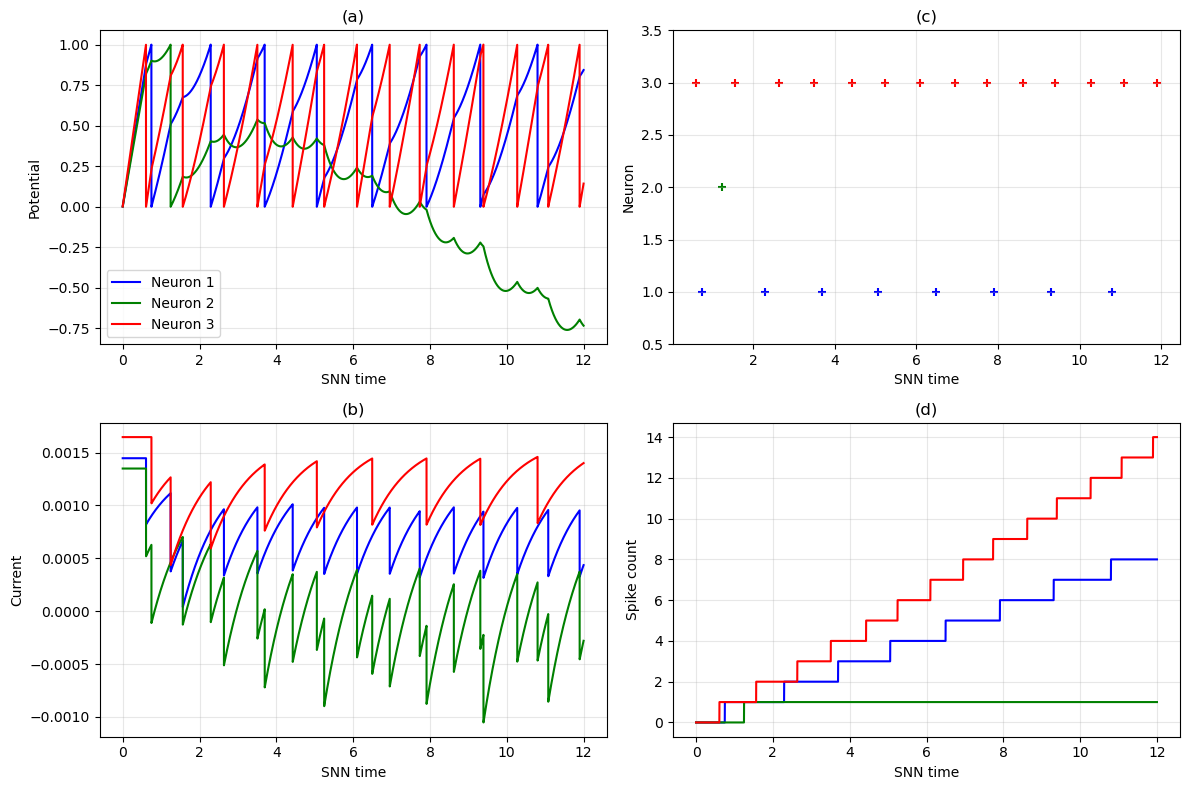


Final Results:
  Reconstruction error: 0.431454
  Active coefficients: 2 / 3
  Total spikes: [8, 1, 14]


In [18]:
# S-LCA Diagnostic Plotting - 4 Panel Figure
import importlib, sys
import numpy as np
import matplotlib.pyplot as plt


Phi_demo = np.array([
    [0.3313, 0.8148, 0.4364],
    [0.8835, 0.3621, 0.2182],
    [0.3313, 0.4527, 0.8729],
], dtype=float)

s_demo = np.array([0.5, 1.0, 1.5], dtype=float)
lam_demo = 0.1
dt = 1e-3
scaffold = Scaffold()

scaffold.add_brick(
    LCABrick(Phi=Phi_demo, input_signal=s_demo, dt=dt, lam=lam_demo),
    output=True
)

scaffold.lay_bricks()
dt = 1e-3
# Compile backend for diagnostic run with logging
backend = slca_Backend()
backend.compile(scaffold=scaffold, compile_args={
    'y': s_demo,
    'Phi': Phi_demo,
    'lam': lam_demo,
    'dt': dt,
    'tau_syn': 1.0,
    'T_steps': 12000,  # longer for better plots
    't0_steps': 100,
})

# Get neuron names from the actual neural network
lca_neurons = [name for name in backend.nn.nrns.keys() if "neuron_" in name and "complete" not in name]
print(f"Found LCA neurons: {lca_neurons}")

# Reset logging arrays for clean plots
for name, neuron in backend.nn.nrns.items():
    if hasattr(neuron, 'v_hist'):
        neuron.v_hist = []
    if hasattr(neuron, 'spike_hist'):
        neuron.spike_hist = []

print(f"Running S-LCA diagnostic for {backend.T_steps} steps ({backend.T_steps*dt:.1f}s)")

# Run step-by-step to collect detailed logging
T_plot = 12.0  # seconds to plot
steps_to_plot = int(T_plot / dt)
time_axis = np.arange(steps_to_plot) * dt

v_traces = {name: [] for name in lca_neurons}
spike_traces = {name: [] for name in lca_neurons}
current_traces = {name: [] for name in lca_neurons}

# Initialize backend state
backend.soma_current[:] = 0.0
backend.int_soma_current[:] = 0.0

for step in range(steps_to_plot):
    backend.slca_step()
    
    # Log data for plotting
    for i, name in enumerate(lca_neurons):
        neuron = backend.nn.nrns[name]
        v_traces[name].append(neuron.v)
        spike_traces[name].append(1.0 if neuron.spike else 0.0)
        # Get soma current from backend state array
        current_traces[name].append(backend.soma_current[i])

# Convert to numpy arrays
for name in lca_neurons:
    v_traces[name] = np.array(v_traces[name])
    spike_traces[name] = np.array(spike_traces[name])
    current_traces[name] = np.array(current_traces[name])

# Create the 4-panel figure
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# (a) Membrane potentials
for i, name in enumerate(lca_neurons):
    color = ['blue', 'green', 'red'][i % 3]
    axes[0,0].plot(time_axis, v_traces[name], color=color, label=f'Neuron {i+1}')
axes[0,0].set_xlabel('SNN time')
axes[0,0].set_ylabel('Potential')
axes[0,0].set_title('(a)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# (b) Soma currents
for i, name in enumerate(lca_neurons):
    color = ['blue', 'green', 'red'][i % 3]
    axes[1,0].plot(time_axis, current_traces[name], color=color, label=f'Neuron {i+1}')
axes[1,0].set_xlabel('SNN time')
axes[1,0].set_ylabel('Current')
axes[1,0].set_title('(b)')
axes[1,0].grid(True, alpha=0.3)

# (c) Spike raster
for i, name in enumerate(lca_neurons):
    spike_times = time_axis[spike_traces[name] > 0.5]
    if len(spike_times) > 0:
        axes[0,1].scatter(spike_times, [i+1]*len(spike_times), 
                         marker='+', s=30, color=['blue', 'green', 'red'][i % 3])
axes[0,1].set_xlabel('SNN time')
axes[0,1].set_ylabel('Neuron')
axes[0,1].set_title('(c)')
axes[0,1].set_ylim(0.5, len(lca_neurons) + 0.5)
axes[0,1].grid(True, alpha=0.3)

# (d) Cumulative spike counts
cumulative_counts = {}
for i, name in enumerate(lca_neurons):
    cumulative_counts[name] = np.cumsum(spike_traces[name])
    color = ['blue', 'green', 'red'][i % 3]
    axes[1,1].plot(time_axis, cumulative_counts[name], color=color, label=f'Neuron {i+1}')
axes[1,1].set_xlabel('SNN time')
axes[1,1].set_ylabel('Spike count')
axes[1,1].set_title('(d)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final results using the actual run method
T_tail = (steps_to_plot - backend.t0_steps) * dt
mu_tail = backend.int_soma_current / max(T_tail, 1e-12)
a_tail = np.maximum(0.0, mu_tail - backend.lam)
x_hat = backend.Phi @ a_tail

print(f"\nFinal Results:")
print(f"  Reconstruction error: {np.linalg.norm(x_hat - s_demo):.6f}")
print(f"  Active coefficients: {np.sum(a_tail>1e-6)} / {len(a_tail)}")
print(f"  Total spikes: {[int(cumulative_counts[name][-1]) for name in lca_neurons]}")